In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt
import torch

from learning import lstd, valuefunc, trajdata
from env import linearenv, controller
from exputils import relerr
from trajgen import quadratic, nonlinear

## I. TrajDataset class

In [9]:
p = 5
q = 3
T = 10
gamma = 0.99

In [14]:
lqrenv = linearenv.random_vanilla_env(p, q, QRratio=10, Anorm=1.0)
xtraj, _, utraj, rtraj, xtraj_, _ = lqrenv.sampletraj(lqrenv.optctrl(), 10, 3000)
dataset = trajdata.TrajDataset(xtraj, utraj, rtraj, xtraj_)

In [16]:
icnnvalue = valuefunc.ICNNValueFunc(p, [50, 50, 1])
icnnvalue.learn(dataset, gamma, num_epoch=400, batch_size=64, verbose=True, print_interval=50, lr=0.005)

Epoch: 1 	 Training loss: 34412.26481661016
Epoch: 51 	 Training loss: 0.8344322429066916
Epoch: 101 	 Training loss: 0.12197177343711411
Epoch: 151 	 Training loss: 0.3148879833724209
Epoch: 201 	 Training loss: 1.0408565879837015
Epoch: 251 	 Training loss: 1.6901979755068013
Epoch: 301 	 Training loss: 0.584377424833005
Epoch: 351 	 Training loss: 0.06393625511043474


## II. Trajectory projection

In [677]:
from trajgen import nonlinearbkup

In [641]:
p = 2
segments = 5
order = 10
numsteps = 1000

In [720]:
waypoints = np.random.randn(p, segments+1)
waypoints[:, 0] = 0
waypoints[:, -1] = 0
ts = np.linspace(0,1,segments+1) * 3

In [733]:
# Generate random coefficients
numseg = waypoints.shape[1] - 1
randcoeffs = torch.randn(p, numseg, order+1).double() * 1000
# Project coefficients to subspace
projcoeff = nonlinear.projectcoeff(waypoints, ts, randcoeffs)

In [734]:
t, randx = nonlinear.coeff2traj(randcoeffs, ts, numsteps)
t, projx = nonlinear.coeff2traj(projcoeff, ts, numsteps)

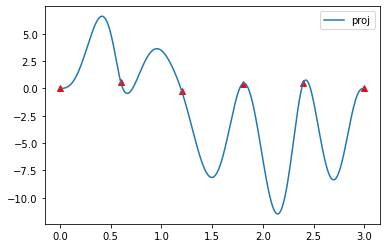

In [737]:
plt.plot(ts, waypoints[1], 'r^')
#plt.plot(t, randx[1], label='rand')
plt.plot(t, projx[1], label='proj')
_ = plt.legend()

## III. Learn to regularize trajectories

In [11]:
p = 2
q = 2
Tref = 15
gamma = 0.99
num_traj = 3000
order = 6
rho = 1

In [58]:
# Create environment and collect data
lqrenv = linearenv.random_vanilla_env(p, q, QRratio=10, Anorm=1.0)
trackingenv = lqrenv.totracking(Tref)
xtraj, _, utraj, rtraj, xtraj_, _ = trackingenv.sampletraj(trackingenv.optctrl(), Tref, num_traj)
dataset = trajdata.TrajDataset(xtraj, utraj, rtraj, xtraj_)

In [60]:
# Learn the tracking cost from data
vf = valuefunc.ICNNValueFunc(trackingenv.p, [200, 200, 1])
vf.learn(dataset, gamma, num_epoch=600, batch_size=64, verbose=True, print_interval=50, lr=0.003)

Epoch: 1 	 Training loss: 142411030.18277174
Epoch: 51 	 Training loss: 54.472228255782184
Epoch: 101 	 Training loss: 11.944257182109975
Epoch: 151 	 Training loss: 4.787311612076885
Epoch: 201 	 Training loss: 17.549347541876358
Epoch: 251 	 Training loss: 6.365908869282922
Epoch: 301 	 Training loss: 4.883638353314946
Epoch: 351 	 Training loss: 4.258109538315651
Epoch: 401 	 Training loss: 2.34874559191743
Epoch: 451 	 Training loss: 0.8290149045114807
Epoch: 501 	 Training loss: 0.35731543453989717
Epoch: 551 	 Training loss: 4.484048318088524


In [61]:
vf.eval()

In [84]:
# Generate a waypoints and the min-jerk trajectory
segments = 5
waypoints = np.random.randn(p, segments+1)
waypoints[:, 0] = 0
waypoints[:, -1] = 0
ts = np.linspace(0,1,segments+1) * 3
Pstar, Kstar = trackingenv.solve(Tref)
_, minjerk_coeffs = quadratic.generate(waypoints.T, ts, order, Tref, p, Pstar, 0)

In [127]:
# Generate regularized trajectory from gradient descent on NN
rho = 1000
nn_coeff = nonlinear.generate(torch.tensor(waypoints), ts, order, Tref, p, rho, vf, torch.tensor(minjerk_coeffs),
                   num_iter=100, lr=0.01)

In [128]:
# Generate trajectory from closed form convex opt
_, sol_coeffs = quadratic.generate(waypoints.T, ts, order, Tref, p, Pstar, rho)

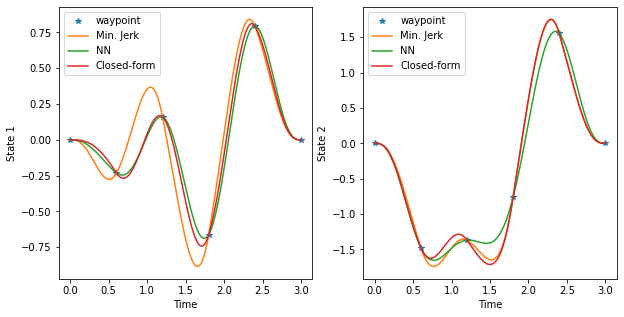

In [167]:
# Plot the trajectories
t, origx = nonlinear.coeff2traj(minjerk_coeffs, ts, 1000)
t, nnx = nonlinear.coeff2traj(nn_coeff, ts, 1000)
t, solx, = nonlinear.coeff2traj(sol_coeffs, ts, 1000)
plt.figure(figsize=(10, 5))
# Dimension 0
plt.subplot(1,2,1)
plt.plot(ts, waypoints[0], '*', label='waypoint')
plt.plot(t, origx[0], label='Min. Jerk')
plt.plot(t, nnx[0], label='NN')
plt.plot(t, solx[0], label='Closed-form')
plt.xlabel('Time')
plt.ylabel('State 1')
plt.legend()

# Dimension 1
plt.subplot(1,2,2)
plt.plot(ts, waypoints[1], '*', label='waypoint')
plt.plot(t, origx[1], label='Min. Jerk')
plt.plot(t, nnx[1], label='NN')
plt.plot(t, solx[1], label='Closed-form')
plt.xlabel('Time')
plt.ylabel('State 2')
plt.legend()

## IV. Visualizations
Run the previous sections before running this one

### i) Trajectories vs. number of PGD iterations 

In [130]:
iterations = [1, 5, 10, 50, 100, 200]
new_coeffs = []
for it in iterations:
    new_coeffs.append(nonlinear.generate(torch.tensor(waypoints), ts, order, Tref,
                                         p, rho, vf, torch.tensor(coeffs), num_iter=it, lr=0.01))

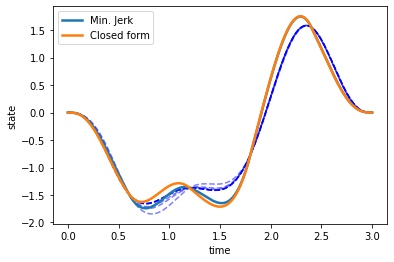

In [132]:
# Plot the trajectories at certain iterations
d = 1
for i,c in enumerate(new_coeffs):
    t, x = nonlinear.coeff2traj(c, ts, 1000)
    #plt.plot(t, x[d], '--', label='Iteration {}'.format(iterations[i]))
    plt.plot(t, x[d], 'b--', alpha=0.5 + iterations[i]/iterations[-1]/2)

# Plot original (min-jerk) trajectory
plt.plot(t, origx[d], linewidth=2.5, label='Min. Jerk')
plt.plot(t, solx[d], linewidth=2.5, label='Closed form')
plt.xlabel('time')
plt.ylabel('state')

_ = plt.legend()

Here the blue curves are the trajectories generated from projected gradient descent on neural networks. The lighter the color of the curve is, the fewer number of iterations it took. So the expectation is that the darkest blue curve (the one with the most steps of gradient descent) should almost match the orange curve.

### ii) Tracking Cost vs. PGD iterations

In [148]:
# Compute tracking cost for the specified PGD iterations
costs = []
for i,c in enumerate(new_coeffs):
    t, x = nonlinear.coeff2traj(c, ts, Tref)
    d0 = torch.cat([x[:, 0], x.T.flatten()]).numpy()
    xtraj, _, utraj, rtraj, xtraj_, _ = \
        trackingenv.sampletraj(trackingenv.optctrl(), Tref, 1, x0s=d0[None, :])
    costs.append(rtraj.sum())
    
# Compute tracking cost for min-jerk traj
_, origx = nonlinear.coeff2traj(minjerk_coeffs, ts, Tref)
d0 = torch.cat([origx[:, 0], origx.T.flatten()]).numpy()
_, _, _, rtraj, _, _ = \
        trackingenv.sampletraj(trackingenv.optctrl(), Tref, 1, x0s=d0[None, :])
orig_cost = rtraj.sum()

# Compute tracking cost for closed-form solution traj
_, solx, = nonlinear.coeff2traj(sol_coeffs, ts, Tref)
d0 = torch.cat([solx[:, 0], solx.T.flatten()]).numpy()
_, _, _, rtraj, _, _ = \
        trackingenv.sampletraj(trackingenv.optctrl(), Tref, 1, x0s=d0[None, :])
sol_cost = rtraj.sum()

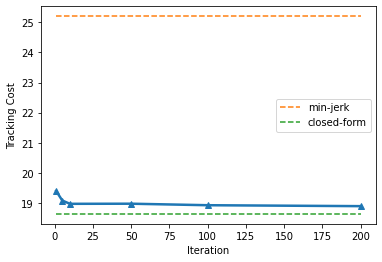

In [165]:
plt.plot(iterations, costs, '^-', linewidth=2.5)
plt.plot(iterations, np.ones(len(iterations)) * orig_cost, label='min-jerk', linestyle='--')
plt.plot(iterations, np.ones(len(iterations)) * sol_cost, label='closed-form', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Tracking Cost')
_ = plt.legend()

As expected, the tracking cost goes down as the number of gradient descent iterations increase, and the marginal return declines. (Note how we decreased the cost by just ~10 gradient steps)

### iii) Runtime vs. PGD iterations

In [158]:
import time

In [159]:
times = []
for it in iterations:
    t = time.time()
    new_coeffs.append(nonlinear.generate(torch.tensor(waypoints), ts, order, Tref,
                                         p, rho, vf, torch.tensor(coeffs), num_iter=it, lr=0.01))
    times.append(time.time() - t)

Text(0, 0.5, 'Time(s)')

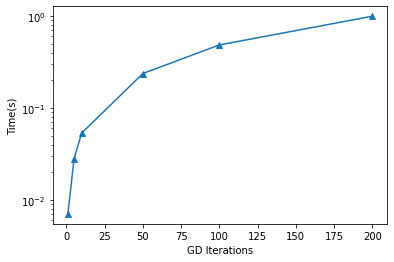

In [162]:
plt.semilogy(iterations, times,'^-')
plt.xlabel('GD Iterations')
plt.ylabel('Time(s)')

The computation time is linear in the number of gradient steps, not surprisingly.